## Item Clustering by User Purchase History
<font color="grey" size = 4><i>Skills: K-means Clustering, PCA, Silhouette Score </i></font>

We have two datasets:<br>
1. ***item_to_id*** which has information on the item and it's corresponding ID to uniquely identify each product.<br>
2. ***purchase_history*** which contains information on user's purchase history. The products users tend to buy together.<br>
We can use these datasets to come up with interesting insights that may help expand the business.

### Business Questions:

#### Target Audience
1. Identify top 10 customers who bought the most items overall
2. For each item, identify the customer who bought that product the most

This will help us identify our most valuable and loyal customers who can then advocate for our business.

#### Cluster Items

1. Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.



In [1]:
import re
from collections import Counter
import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Load and Inspect Data

There are 48 unique items in the inventory.

In [5]:
item = pd.read_csv("item_to_id.csv")
item.head()
item.sort_values(by = 'Item_id')

,Item_name,Item_id
18,sugar,1
35,lettuce,2
47,pet items,3
46,baby items,4
20,waffles,5
23,poultry,6
41,sandwich bags,7
15,butter,8
3,soda,9
32,carrots,10


In [6]:
purchase = pd.read_csv('purchase_history.csv')
purchase.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


#### Data Summary

There are 39,474 purchases made by 24,885 unique customers. Data has no missing values.

In [7]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [8]:
purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [9]:
len(purchase.user_id.unique())

24885

In [10]:
purchase.isnull().sum()

user_id    0
id         0
dtype: int64

#### Data Pre-processing

In order to get any meaningful insights from the dataset, we will have to some pre-processing. We will create a frequency table for each item by every user. If a user buys a specific item 2 times we will have (user,item) = 2 in the table.

In [11]:
def count_items(df):
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1,49)]
    for i in ids:
        id_list[int(i)-1]+=1
    return pd.Series(id_list,index = list(range(1,49)))


In [12]:
user_item_cnt = purchase.groupby('user_id').apply(count_items)
user_item_cnt.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


### Top 10 customers who bought the most items

In [21]:
user_count = user_item_cnt.sum(axis = 1).sort_values(ascending = False).reset_index().rename(columns = {0:'item_cnt'})
user_count.head(10)

,user_id,item_cnt
0,269335,72
1,367872,70
2,599172,64
3,397623,64
4,377284,63
5,1485538,62
6,917199,62
7,718218,60
8,653800,60
9,828721,58


### For each item, the customer who bought that product the most

In [16]:
item_max = user_item_cnt.apply(lambda s : pd.Series([s.argmax(),s.max()],index = ['max_user','max_cnt']))
item_max = item_max.transpose()
item_max.index.name = 'Item_id'
item_max

,max_user,max_cnt
Item_id,,
1,512,4
2,512,5
3,2552,4
4,92,3
5,3605,3
6,5555,4
7,2926,3
8,2493,3
9,4445,4


We were able to get all the users who bought maximum number of each item.Identifying a target audience provides a clear focus of whom your business will serve and why those consumers need your goods or services. Determining this information also keeps a target audience at a manageable level.

## Clustering of Items

### Item-Item Similiarity Matrix

To cluster items we would first create a cosine similarity matrix.<br>
***Cosine similarity*** is a metric that can be used to determine how similar the documents/terms are irrespective of their magnitude.
Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space.When plotted on a multi-dimensional space, where each dimension corresponds to a word , the cosine similarity captures the orientation (the angle) of the terms and not the magnitude. If you want the magnitude, compute the Euclidean distance instead.

The cosine similarity is advantageous because even if the two similar items are far apart by the Euclidean distance because of the size (like, the word ‘fruit’ was purchased 10 times by 1 user and 1 time by other) they could still have a smaller angle between them. Smaller the angle, higher the similarity. 

In [27]:
user_item_cnt.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [45]:
user_item_cnt_transpose = user_item_cnt.T
similarity = cosine_similarity(user_item_cnt_transpose,user_item_cnt_transpose)
similarity_df = pd.DataFrame(similarity, index=user_item_cnt.columns, columns=user_item_cnt.columns)

In [47]:
similarity_df[:5]

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


### Feature Selection Using PCA

Now that we have the similarity matrix, we can cluster the items based on the cosine similarity score but before that we will use PCA to reduce the dimension of the dataset.<br>
PCA will help us to discover which dimensions in the dataset best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone.

In [116]:
pca_model = PCA()
items_rotate = pca_model.fit_transform(similarity_df)

items_rotate = pd.DataFrame(items_rotate,index=user_item_cnt.columns,
                        columns=["pc{}".format(idx+1) for idx in range(item.shape[0])])
items_rotate.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48
1,0.355639,-0.025103,-0.051129,-0.039214,-0.049529,0.003300,0.019830,-0.011458,0.084798,-0.042284,...,-0.019760,-0.012837,-0.006332,-0.022289,-0.002654,-0.001332,0.011263,-0.026911,-0.129284,5.732095e-17
2,0.793894,-0.041103,0.013244,-0.009035,-0.141627,-0.036540,-0.114816,-0.087070,0.000959,-0.035030,...,-0.039028,-0.015895,-0.027280,0.017406,0.013680,0.004437,-0.030161,0.006713,0.379136,5.732095e-17
3,0.135668,-0.029584,-0.028246,-0.012556,-0.013317,0.004220,-0.020503,-0.050246,0.177599,-0.080864,...,0.020455,-0.007168,0.040652,0.004387,0.029288,0.000224,0.009908,0.001288,-0.035429,5.732095e-17
4,-0.532034,0.020259,-0.022628,-0.037650,0.022756,-0.046219,0.042124,-0.132828,0.651482,-0.274771,...,0.000133,0.002444,0.005894,-0.003617,-0.005383,0.001555,-0.006114,0.007527,0.020217,5.732095e-17
5,-0.678770,-0.093874,-0.347623,-0.232866,-0.090366,-0.057124,-0.018074,0.038866,-0.048059,-0.014378,...,-0.008466,0.011890,0.002598,0.007605,0.009321,-0.003278,0.006540,0.000677,0.023603,5.732095e-17


### Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the cumulative explained variance ratio is extremely important for knowing how many dimensions are necessary for the problem. We can even visualize the components and variance explained by each of them.

Text(0.5, 1.0, 'Explained variance plot')

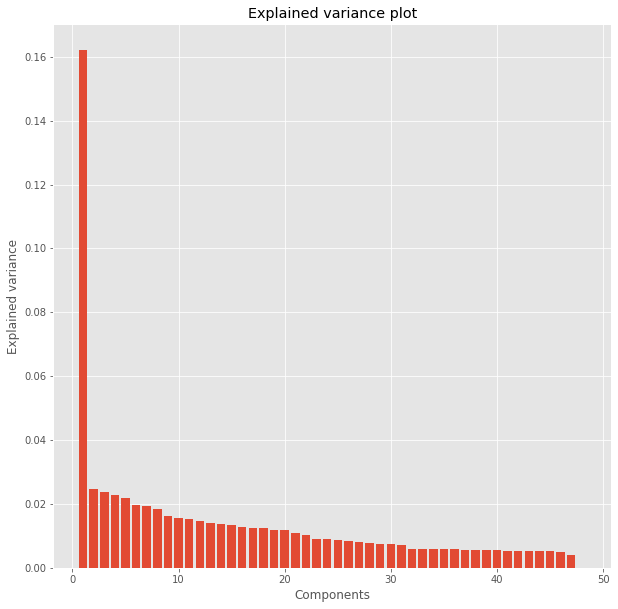

In [117]:
fig = plt.figure(figsize=(10, 10))
plt.bar(range(1,len(pca_model.explained_variance_)+1),pca_model.explained_variance_)
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.title("Explained variance plot")

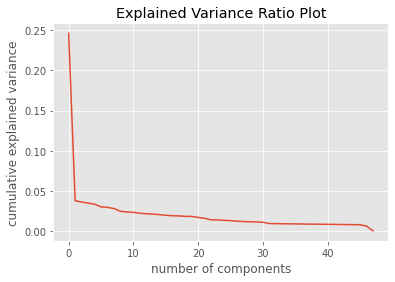

In [118]:
plt.plot(pca_model.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("Explained Variance Ratio Plot")
plt.show()

Text(0.5, 1.0, 'PCA Cumulative Variance Plot')

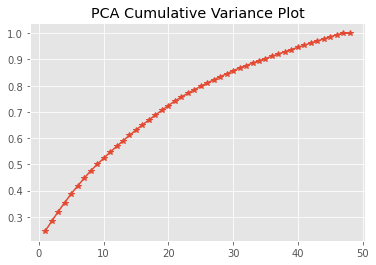

In [119]:
# show the total variance which can be explained by first K principle components
explained_variance_by_k = pca_model.explained_variance_ratio_.cumsum()

plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")
plt.title("PCA Cumulative Variance Plot")

We can see 35 principal components can explain upto 90% variance in the dataset. 

In [121]:
sum(pca_model.explained_variance_ratio_[:35])

0.9036104968698064

### K-means Clustering

We are going to use K-means clustering to identify the clusters for our items.<br>
Advantages of k-means
1. Relatively simple to implement.
2. Scales to large data sets.
3. Guarantees convergence.
4. Easily adapts to new examples.
5. Generalizes to clusters of different shapes and sizes, such as elliptical clusters.<br>

***Random Initialization***:
In some cases, if the initialization of clusters is not appropriate, K-Means can result in arbitrarily bad clusters. This is where K-Means++ helps. It specifies a procedure to initialize the cluster centers before moving forward with the standard k-means clustering algorithm. It will randomly choose a centroid, calculate the distance of every point from it and the point which has the maximum distance from the centroid will be chosen as the second centroid.

#### Creating Clusters
When the number of clusters is not known a priori like in this problem, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's ***silhouette coefficient*** and ***inertia***.<br>
The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the mean silhouette coefficient provides for a simple scoring method of a given clustering.<br>
Inertia: It is defined as the mean squared distance between each instance and its closest centroid. Logically, as per the definition lower the inertia better the model.

In [111]:
#We will use 25 pca components
items_filter = items_rotate.values[:,:25]

In [112]:
clusters = range(5, 20)
inertias = []
silhouettes = []

for n_clusters in clusters:
    model = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_jobs=1)
    label = model.fit_predict(items_filter)
    
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(items_filter, label))

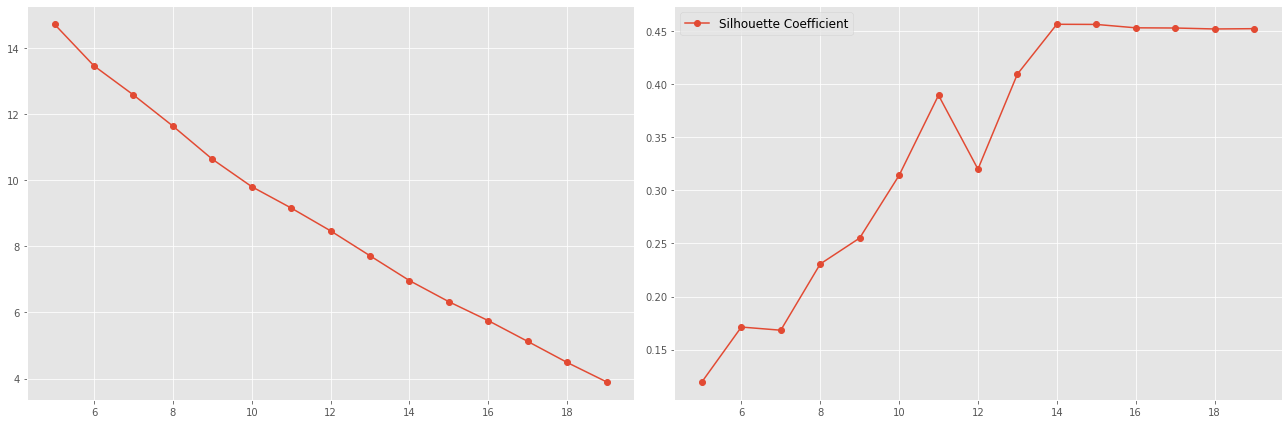

In [113]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


Silhouette coefficient plateaued after 14 so 14 clusters look optimal.

### Cluster Visualization

We can see 14 clusters are created and items are clearly sorted. We were able to reduce dimensionality and ended up using just 25 features.<br>
Items are sorted as bakery items(Cluster 4) such as bagels
,tortillas
,dinner rolls
,sandwich loaves and canned goods(cluster 1) such as  spaghetti sauce
,canned vegetables
,ketchup. Similarly, we have other clusters as well.

In [125]:
def show_clusters(items_rotated,labels):
    """
    plot and print clustering result
    """
    fig = plt.figure(figsize=(15, 15))
    colors =  itertools.cycle (["blue","green","red","cyan","yellow","purple","orange","olive","seagreen","magenta","brown","lightpink","indigo","aqua","teal"])

    grps = items_rotated.groupby(labels)
    for label,grp in grps:
        #print(label,grp)
        plt.scatter(grp.pc1,grp.pc2,c=next(colors),label = label)

        print("*********** Label [{}] ***********".format(label))
        print(grp.index)
        for j in grp.index:
            
            names = item[item['Item_id'] == j]["Item_name"].to_string(index = False)
            print(j,names)
            
        

    # annotate
    for itemid in items_rotated.index:
        x = items_rotated.loc[itemid,"pc1"]
        y = items_rotated.loc[itemid,"pc2"]
        name = item[item['Item_id'] == itemid]["Item_name"].to_string(index = False)
        plt.text(x,y,name)

In [126]:
def cluster(n_clusters,n_components=48):
    """
    n_components=K, means use first K principle components in the clustering
    n_clusters: the number of clusters we want to cluster
    """
    print("first {} PC explain {:.1f}% variances".format(n_components,
                                                         100 * sum(pca_model.explained_variance_ratio_[:n_components])))

    kmeans_model = KMeans(n_clusters=n_clusters,init='k-means++', random_state=42, n_jobs=1)
    kmeans_model.fit(items_rotate.values[:, :n_components])

    # display results
    show_clusters(items_rotate, kmeans_model.labels_)

first 25 PC explain 79.8% variances
*********** Label [0] ***********
Int64Index([26, 28, 41], dtype='int64')
26  spaghetti sauce
28  canned vegetables
41  ketchup
*********** Label [1] ***********
Int64Index([30], dtype='int64')
30  flour
*********** Label [2] ***********
Int64Index([1, 3, 20, 25, 32, 40, 46], dtype='int64')
1  sugar
3  pet items
20  grapefruit
25  cherries
32  apples
40  berries
46  bananas
*********** Label [3] ***********
Int64Index([12, 19, 29, 35], dtype='int64')
12  shampoo
19  shaving cream
29  hand soap
35  soap
*********** Label [4] ***********
Int64Index([13, 34, 37, 39], dtype='int64')
13  bagels
34  tortillas
37  dinner rolls
39  sandwich loaves
*********** Label [5] ***********
Int64Index([7, 15, 24, 33], dtype='int64')
7  sandwich bags
15  aluminum foil
24  paper towels
33  toilet paper
*********** Label [6] ***********
Int64Index([2, 10, 42, 44, 45], dtype='int64')
2  lettuce
10  carrots
42  cucumbers
44  broccoli
45  cauliflower
*********** Label [7] *

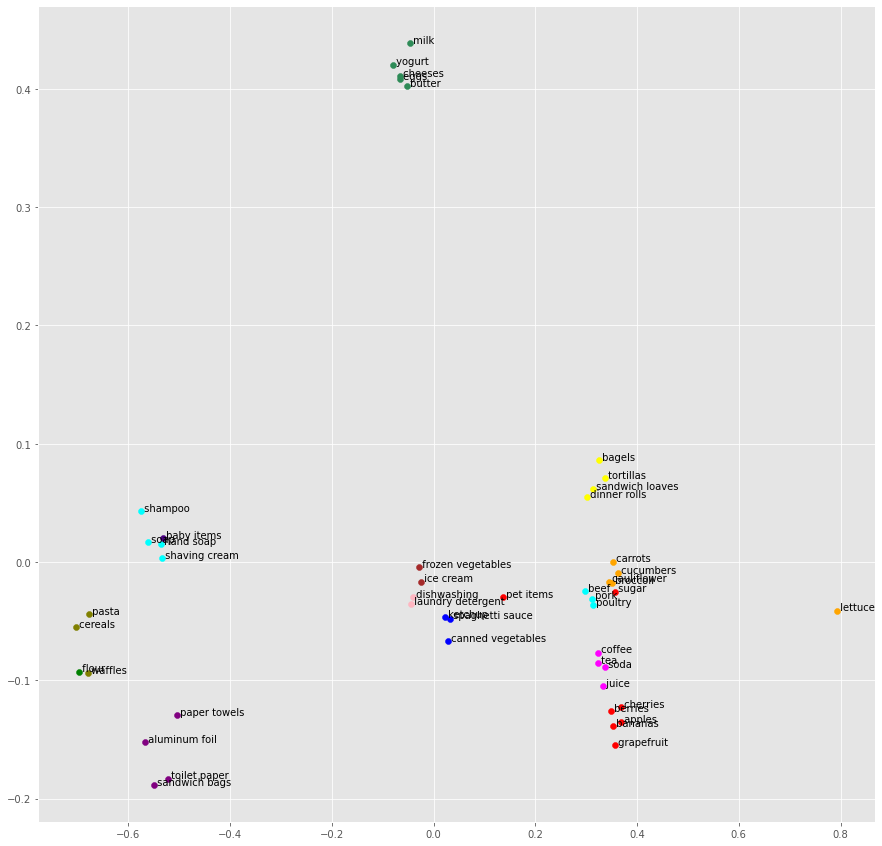

In [128]:

cluster(n_clusters = 14,n_components=25)